# **3D simulation and fitting**

## **Prerequisites**

- Knowledge of 3D extraction and datasets used in gammapy, see for instance the [first analysis tutorial](https://docs.gammapy.org/0.18.2/tutorials/analysis_1.html)

## **Context**

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement (performance / sensitivity study), to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 3D simulation of a CTA observation, assuming both the spectral and spatial morphology of an observed source.

**Objective: simulate a 3D observation of a source with CTA using the CTA 1DC response and fit it with the assumed source model.**

## **Proposed approach**

Here we can't use the regular observation objects that are connected to a `DataStore`. Instead we will create a fake `~gammapy.data.Observation` that contain some pointing information and the CTA 1DC IRFs (that are loaded with `~gammapy.irf.load_cta_irfs`).

Then we will create a `~gammapy.datasets.MapDataset` geometry and create it with the `~gammapy.makers.MapDatasetMaker`.

Then we will be able to define a model consisting of  a `~gammapy.modeling.models.PowerLawSpectralModel` and a `~gammapy.modeling.models.GaussianSpatialModel`. We will assign it to the dataset and fake the count data.


## **Imports and versions**

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation
from gammapy.datasets import MapDataset

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.18.2     
	path                   : /home/khelifi/MesProgrammes/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy 



## **Simulation**

We will simulate using the CTA-1DC IRFs shipped with gammapy. Note that for dedictaed CTA simulations, you can simply use [`Observation.from_caldb()`]() without having to externally load the IRFs.

**Loading IRFs**

In [4]:
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


**Define the observation parameters**  
typically the observation duration and the pointing position

In [5]:
livetime = 2.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

**Define map geometry for binned simulation**

In [6]:
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

**Define the sky and background models to be used for the simulation**  
Here we use a Gaussian spatial model and a Power Law spectral model.

In [7]:
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   3.000              
    amplitude               :   1.00e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   :   0.200  deg         
    lat_0                   :   0.100  deg         
    sigma                   :   0.300  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (fro

**The simulations**  
Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [8]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.08
	duration          : 7200.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [9]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

safe_mask_maker = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = safe_mask_maker.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : nan 
  Total background counts         : 161250.95
  Total excess counts             : nan

  Predicted counts                : 161250.95
  Predicted background counts     : 161250.95
  Predicted excess counts         : nan

  Exposure min                    : 6.41e+07 m2 s
  Exposure max                    : 2.53e+10 m2 s

  Number of total bins            : 0 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [10]:
# Add the model on the dataset and Poission fluctuate
%time
dataset.models = models
dataset.fake()

# Do a print on the dataset - there is now a counts maps
print(dataset)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs
MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 169845 
  Total background counts         : 161250.95
  Total excess counts             : 8594.05

  Predicted counts                : 169690.08
  Predicted background counts     : 161250.95
  Predicted excess counts         : 8439.14

  Exposure min                    : 6.41e+07 m2 s
  Exposure max                    : 2.53e+10 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 563766.96

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : Ga

**Control plot**  
Now use this dataset as you would in all standard analysis. You can plot the maps, or proceed with your custom analysis. 
In the next section, we show the standard 3D fitting as in [analysis_3d](analysis_3d.ipynb).

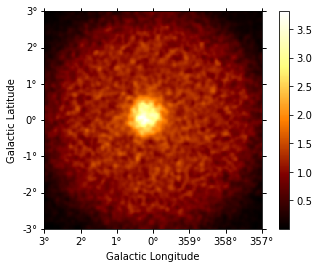

In [11]:
# To plot, eg, counts:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(add_cbar=True, stretch="linear")

**Write your simulated data**

In [12]:
dataset.write("fake_simu.fits", overwrite=True)
#Serialisation of the sky model
dataset.models.write("fake_model.yaml", full_output=True)

OSError: File exists already: fake_model.yaml

## **Summary**

In a large number of science use cases, it is only necessary to realise simulations in a binned dataset, which brings a huge time gain. The `fake()` function of the datasets is the simple key command.  
After your simulated, you can serialise the results on disk.


## **Exercises**  
* Make a 3D analysis of your simulated dataset, using the created fits file
* Study some systematic errors, e.g.
  * make a simulation with a modified background model (e.g. changing the tilt)
  * do the 3D analysis by imposing a 'normal' tilt, ie tilt=0